@author: Xinyu Li

@last updated: Aug 22 

#### Initialize Parameter
Paramters about the meal, insulin dynamics, minimal model, cost function weights, and time descritization are set in the following cell

In [1]:
# %load Initialization
# Author: Xinyu Li
# Email: xl1796@nyu.edu
# Date: August 2019
# Description: Some parameters and inputs are initialized here

import numpy as np

## Meal Input
# meal time
tk_list  = [60, 350, 720]      #unit: min
# the time that the subject take the meal
meal_time=5
# meal intake value
qk_list  = np.array([3000, 4500, 3500])/meal_time  #unit: mg/min, from ref 1 in Xinyu's writeup

# digestion coefficient
tau      = 100                 #unit: 1  [unknown parameter!!!]
# initial glucose rate of appearance
Ra_0     = 5                   #unit: mg/kg/min

## Insulin Parameter
c1       = 0.25                #unit: min^-1   [unknown parameter!!!]
c2       = 0.2                 #unit: min^-1   [unknown parameter!!!]
I0       = 0.38                #unit: mU/l     [unknown initial condition]
Ib       = 0

## Minimal Model Parameter
p1       = 0.6                 #param determined by bio-experiments (unit: min^-1)
p2       = 0.0122              #unit: min^-1
p3       = 1.7e-5              #unit: min^-2 mU/l
Gb       = 125                 #basal plasma glucose (unit:mg/dl)
G0       = 130
X0       = 0
"""A fasting blood sugar level less than 100 mg/dL (5.6 mmol/L) is normal.
 A fasting blood sugar level from 100 to 125 mg/dL (5.6 to 6.9 mmol/L) is considered prediabetes.
  If it's 126 mg/dL (7 mmol/L) or higher on two separate tests, you have diabete"""

## Cost function parameter
lam      = 0.5

## Code Parameter
end_time = 1000                 #unit: min
N        = int(end_time*2+1)    #num of time step
t_list   = np.linspace(0, end_time, N)
h        = t_list[1]-t_list[0]
dt       = 5                    #unit: min
N_meas   = int(end_time/dt+1)   #num of measurements
meas_time= np.linspace(0, end_time, N_meas)


#### Meal Intake Function D(t)
The meal model is piecewise constant. We temporarily assume the meal time is 5 min. The meal intake value and meal time are set in Initialization cell. Later, we can replace them with some random process.

In [2]:
# %load Meal
# Author: Xinyu Li
# Email: xl1796@nyu.edu
# Date: August 2019
# Description: Meal intake function are defined here


def D(t, tk_list, qk_list, meal_time):
    """meal intake function is a piecewise constant one, starting from meal time, and last for 5mins
    @:param tk_list:     a list of time when meal intake happens
    @:param qk_listL     a list of meal intake value"""

    for i in range(len(tk_list)):
        if t-tk_list[i]<meal_time and t>tk_list[i]:
            return qk_list[i]
    return 0

#### Linear Interpolation
The following Linear_approx is a tool box that provides interpolation tools.
1. Linear interpolation
2. Piecewise constant interpolation

In [3]:
# %load Linear_approx
# Author: Xinyu Li
# Email: xl1796@nyu.edu
# Date: August 2019
# Description: Some tools to determine function value based on linear approximation has been included here
import numpy as np

def Linear_interpolation(t, I_list, t_list):
    """ Find out I at time t using a linear interpolation between two points in t_list
    @:param t:         given time
    @:param I_list:    a list of function values with respect to t
    @:param t_list:    the corresponding time discretization """

    # np.searchsorted - return i satisfies t_list[i-1] <= t < t_list[i]
    idx1 = np.searchsorted(t_list, t, side="right") - 1
    idx2 = idx1+1

    if idx2<len(I_list):
        y1   = I_list[idx1]
        y2   = I_list[idx2]
        x1   = t_list[idx1]
        x2   = t_list[idx2]
        I_t  = (y2-y1)/(x2-x1)*(t-x1)+y1
        return I_t
    return I_list[-1]


def Constant_interpolation(t, I_list, t_list):
    """ Find out function I at time t using a piecewise constant approximation between two points in t_list
        @:param t:         given time
        @:param I_list:    a list of function values with respect to t
        @:param t_list:    the corresponding time discretization """

    idx1 = np.searchsorted(t_list, t, side="right") - 1 # t_list[idx1]<= t < t_list[idx1+1]
    return I_list[idx1]


#### Minimal Model ODE solver
1. The minimal model 
2. The dynamics of Insulin 
3. Glucose appearance rate

In [4]:
# %load ODE_solver
# Author: Xinyu Li
# Email: xl1796@nyu.edu
# Date: August 2019
# Description: This program is a differential equation solver for minimal model

from scipy.integrate import odeint

def dMiniMod(x, t, p1, p2, p3, Gb, Ib, tau, c1, c2, vn_list, t_list, tk_list, qk_list, meal_time):
    """ ODE for minimal model
    @:param p1, p2, p3: bio parameters (unit: min^-1, min^-1, min^-1 mU/l)
    @:param Gb, Ib:     basal plasma glucose (mmol/l) and insulin (mU/l)
    @:param tau:        a constant parameter associated with digestion efficiency
    @:param c1:         constant parameter in the insulin ODE model
    @:param c2:         constant parameter in the insulin ODE model
    @:param vn_list:    a list of control exerted on the model
    @:param t_list:     time descritization for the whole simulation
    @:param tk_list:    a list of meal time
    @:param qk_list:    a list of glucose input from meal    
    @:param meal_time:  how long a meal intake last"""

    G  = x[0]
    X  = x[1]
    I  = x[2]
    Ra = x[3]
    vn = Constant_interpolation(t, vn_list, t_list)  # function linear_func could also be used on vn_list

    dG_dt = -(p1 + X) * G + p1 * Gb + Ra
    dX_dt = -p2 * X + p3 * (I - Ib)
    dI_dt = -c1 * I + c2 * vn
    dRa_dt= -1/tau*(Ra - D(t, tk_list, qk_list, meal_time))

    return [dG_dt, dX_dt, dI_dt, dRa_dt]


def Minimod_ODE_solver(G0, X0, I0, Ra_0, sub_t_list, p1, p2, p3, Gb, Ib, tau, c1, c2, vn_list,t_list, tk_list, qk_list, meal_time):
    """ ODE for minimal model
    @:param G0:         initial condition of glucose level
    @:param X0:         initial condition of remote insulin level
    @:param I0:         initial condition of insulin level
    @:param Ra_0:       initial condition of glucose appearance rate
    @:param sub_t_list: time discretization for the simulation
    @:param p1, p2, p3: bio parameters (unit: min^-1, min^-1, min^-1 mU/l)
    @:param Gb, Ib:     basal plasma glucose (mmol/l) and insulin (mU/l)
    @:param tau:        a constant parameter associated with digestion efficiency
    @:param c1:         constant parameter in the insulin ODE model
    @:param c2:         constant parameter in the insulin ODE model
    @:param vn_list:    a list of control exerted on the model
    @:param t_list:     time descritization for the whole simulation
    @:param tk_list:    a list of meal time
    @:param qk_list:    a list of glucose input from meal    
    @:param meal_time:  how long a meal intake last"""

    ## initial condition for [G, X]
    x0     = [G0, X0, I0, Ra_0]

    ## Solve ODE system
    x      = odeint(dMiniMod, x0, sub_t_list, args=(p1, p2, p3, Gb, Ib, tau, c1, c2, vn_list, t_list, tk_list, qk_list, meal_time))

    ## return the result
    G  = x[:,0]
    X  = x[:,1]
    I  = x[:,2]
    Ra = x[:,3]

    return G, X, I, Ra



#### Model Simulation
In the Simulation.py, the ODE solver would be called repeatedly when new measurement happens.

In [5]:
# %load Simulation
# Author: Xinyu Li
# Email: xl1796@nyu.edu
# Date: August 2019
# Description: This program simulate the process with filter

import numpy as np

def path_generator(vn_list, p1, p2, p3, Gb, Ib, I0, c1, c2, meas_time, t_list, tau, G0,X0, Ra_0, dt, h, tk_list, qk_list, meal_time):
    """this function generates the path given control vn_list
    @:param vn_list:                         a list of controls. dimension = len(t_list)
    @:param p1, p2, p3, Gb, Ib, I0, c1, c2:  bio parameters
    @:param meas_time:                       the time where measurement happens
    @:param t_list:                          time discretization
    @:param tk_list, qk_list:                food intake time and food intake value
    @:param tau:                             digestion parameter
    @:param G0,X0,Ra_0:                      initial conditions of glucose level, remote insulin level, glucose disappearance rate
    @:param dt, h:                           time step between two measurements, time step of time discretization"""

    Gn         = G0
    Xn         = X0
    In         = I0
    Ra_n       = Ra_0

    G_list     = [G0]
    X_list     = [X0]
    I_list     = [I0]
    Ra_list    = [Ra_0]

    N_meas     = len(meas_time)

    for i in range(N_meas-1):
        ## Discretize to sub section in one dt
        sub_t_list  =  t_list[int(i*dt/h): int((i+1)*dt/h+1)]
        #sub_I_list  =  I_list[int(i*dt/h): int((i+1)*dt/h+1)]

        ## Solve the ODE in the sub section
        G, X, I, Ra = Minimod_ODE_solver(Gn, Xn, In, Ra_n, sub_t_list, p1, p2, p3, Gb, Ib, tau, c1, c2, vn_list,t_list, tk_list, qk_list, meal_time)

        ## Update Gn as the initial condition for the next iteration
        Gn  = G[-1]
        Xn  = X[-1]
        In  = I[-1]
        Ra_n= Ra[-1]

        ## Record
        G_list.extend(list(G[1:]))
        X_list.extend(list(X[1:]))
        I_list.extend(list(I[1:]))
        Ra_list.extend(list(Ra[1:]))

    return np.array(G_list), np.array(X_list), np.array(I_list), np.array(Ra_list)

#### Main function to run the simulation

In [6]:
# %load main
# Author: Xinyu Li
# Email: xl1796@nyu.edu
# Date: August 2019
# Description: The main function to run the model

import numpy as np
import matplotlib.pyplot as plt

## a no control simulation
v0_list = np.zeros([1, len(t_list)])[0]   # a control list which is zero 
G_no_c, X_no_c, I_no_c, Ra_no_c = path_generator(v0_list, p1, p2, p3, Gb, Ib, I0, c1, c2, meas_time, t_list, tau, G0,X0, Ra_0, dt, h, tk_list, qk_list, meal_time)

## Some simple control on insulin injection; later will be replaced by control from SGD
vn_list = np.zeros([1, len(t_list)])[0]
vn_list[100:280] = 240
vn_list[600:1000] = 300
vn_list[1400:1700] = 120

#simulation with control
G, X, I, Ra = path_generator(vn_list, p1, p2, p3, Gb, Ib, I0, c1, c2, meas_time, t_list, tau, G0,X0, Ra_0, dt, h, tk_list, qk_list, meal_time)


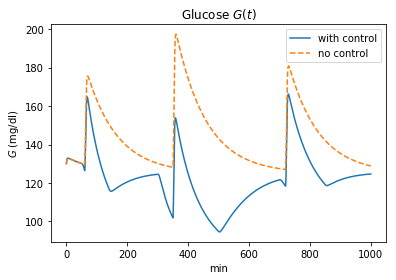

In [7]:
# compare with control and no control senario
plt.plot(t_list , G, label="with control")
plt.plot(t_list, G_no_c, '--',label="no control")
plt.title("Glucose $G(t)$")
plt.xlabel("min")
plt.ylabel("$G$ (mg/dl)")
plt.legend()
plt.show()


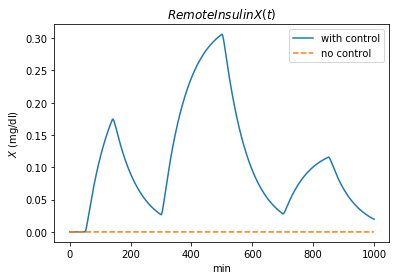

In [8]:
plt.plot(t_list , X, label="with control")
plt.plot(t_list, X_no_c, '--',label="no control")
plt.title("Remote Insulin $X(t)$")
plt.xlabel("min")
plt.ylabel("$X$ (mg/dl)")
plt.legend()
plt.show()


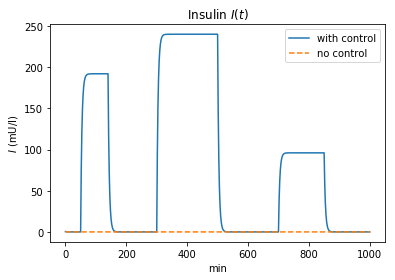

In [9]:
plt.plot(t_list,I, label ="with control")
plt.plot(t_list,I_no_c,'--',label ="no control")
plt.title("Insulin $I(t)$")
plt.xlabel("min")
plt.ylabel("$I$ (mU/l)")
plt.legend()
plt.show()


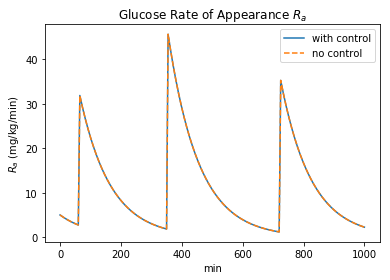

In [10]:
plt.plot(t_list,Ra, label ="with control")
plt.plot(t_list,Ra_no_c,'--',label ="no control")
plt.title("Glucose Rate of Appearance $R_a$")
plt.xlabel("min")
plt.ylabel("$R_a$ (mg/kg/min)")
plt.legend()
plt.show()


##### Remark:
We can see that the glucose level can be efficiently affected by the control control

However, I am not sure whether such high inusulin level are normal.

Insulin control will not affect Glucose Rate of Appearance, which agrees with the ODE model.

#### Measurement Generation

Measurement generation with be applied to the same control list vn. 

However, the parameters of the model are different, and the true parameters are set inside the function in the below cell.

In [11]:
# %load Measurement
# Author: Xinyu Li
# Email: xl1796@nyu.edu
# Date: August 2019
# Description: Generate noisy measurements here

import numpy as np
import matplotlib.pyplot as plt

def measurement_generation(vn_list, t_list,  dt,h, meas_time):
    """a function in order to generate noisy measurements
    @:param t_list:           time discretization
    @:param tk_list, qk_list: meal time and meal intake amount
    @:param dt:               interval between two measurements"""
    ## Minimal Model Parameter to generate measurements
    p1 = 0.6  # param determined by bio-experiments (unit: min^-1)
    p2 = 0.0122  # unit: min^-1
    p3 = 1.7e-5  # unit: min^-2 mU/l
    Gb = 125  # basal plasma glucose (unit:mg/dl)
    G0 = 130
    X0       = 0
    Ra_0     = 0
    ## Insulin Parameter
    c1 = 0.25  # unit: min^-1   [unknown parameter!!!]
    c2 = 0.2  # unit: min^-1   [unknown parameter!!!]
    I0 = 0.38  # unit: mU/l     [unknown initial condition]
    Ib = 0

    # digestion coefficient
    tau      = 100                  #unit: 1  [unknown parameter!!!]

    #variance of measurement noise
    var      = 10

    # true meal model
    tk_list = [60, 350, 720]  # unit: min
    # the time that the subject take the meal
    meal_time = 5
    # meal intake value
    qk_list = np.array([3000, 4500, 3500]) / meal_time  # unit: mg/min, from ref 1 in Xinyu's writeup

    G, X, I, Ra = path_generator(vn_list, p1, p2, p3, Gb, Ib, I0, c1, c2, meas_time, t_list, tau, G0,X0, Ra_0, dt, h, tk_list, qk_list, meal_time)

    model_meas = G[::int(dt/(t_list[1]-t_list[0]))]
    true_meas= model_meas+ np.random.normal(0, var, [len(model_meas)])
    return true_meas

def Plot_measurement(noisy_meas, t_list, dt):
    plt.plot(t_list[::int(dt/(t_list[1]-t_list[0]))], noisy_meas,'o')
    plt.title("Glucose Measurements")
    plt.xlabel("min")
    plt.ylabel("$G$ (mg/dl)")
    plt.show()


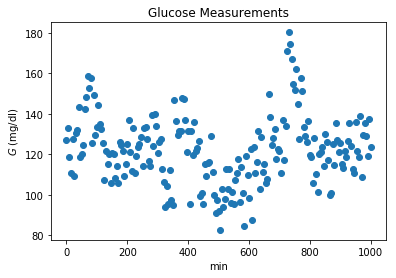

In [12]:
noisy_meas = measurement_generation(vn_list, t_list,  dt,h, meas_time)
Plot_measurement(noisy_meas, t_list, dt)

#### Cost Computation

$$ J(v_0, v_n, ..., v_N) = \int_0^{t_N} (\hat{G}(t) - G_b)^2 dt + \lambda \sum_{n=0}^N{v_n} $$

In [13]:
# %load Cost
# Author: Xinyu Li
# Email: xl1796@nyu.edu
# Date: August 2019
# Description: The cost is calculated here

import numpy as np

def cost_computation(G, Gb, lam, vn_list, end_time):
    """a function to calculate the total cost from time 0 to t1
    :param I_t   the value of insulin I(t) by simulation
    :param Ib    basal insulin value
    :param G     simulation result of glucose function
    :param Gb    basal glucose value
    :param lam   coefficient that determine the ratio of two parts in cost function
    :return total cost"""


    dt_G = end_time/(len(G) - 1)
    return lam*np.sum(vn_list)  + np.sum((G-Gb)**2 * dt_G)


In [14]:
# find out the cost
print("cost with control:", cost_computation(G, Gb, lam, vn_list, end_time))
print("cost without control:", cost_computation(G_no_c, Gb, lam, vn_list, end_time))

cost with control: 302077.06303987175
cost without control: 721095.8700371974
